介绍如何在tensorflow环境下，使用JSMA算法攻击基于Inception数据集预训练的alexnet模型。

Jupyter notebook中使用Anaconda中的环境需要单独配置，默认情况下使用的是系统默认的Python环境，以使用advbox环境为例。
首先在默认系统环境下执行以下命令，安装ipykernel。

    conda install ipykernel
    conda install -n advbox ipykernel

在advbox环境下激活，这样启动后就可以在界面上看到advbox了。

    python -m ipykernel install --user --name advbox --display-name advbox 


In [1]:
import logging
logging.basicConfig(level=logging.INFO,format="%(filename)s[line:%(lineno)d] %(levelname)s %(message)s")
logger=logging.getLogger(__name__)

import numpy as np
from PIL import Image
#pip install Pillow
from advbox.adversary import Adversary
from advbox.attacks.saliency import JSMA
from advbox.models.tensorflow import TensorflowModel
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tools import show_images_diff

In [2]:
#定义被攻击的图片
imagename="tutorials/cropped_panda.jpg"
#从'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'下载并解压到当前路径
dirname="classify_image_graph_def.pb"

In [3]:
#加载解码的图像 这里是个大坑 tf提供的imagenet预训练好的模型pb文件中 包含针对图像的预处理环节 即解码jpg文件 这部分没有梯度
#需要直接处理解码后的数据
image=np.array(Image.open(imagename).convert('RGB').resize((224,224))).astype(np.float32)
#[100,100,3]->[1,100,100,3]

orig=image.copy().astype(np.uint8) 

image=np.expand_dims(image, axis=0)

  

session=tf.Session()

def create_graph(dirname):
    with tf.gfile.FastGFile(dirname, 'rb') as f:
        graph_def = session.graph_def
        graph_def.ParseFromString(f.read())

        _ = tf.import_graph_def(graph_def, name='')

create_graph(dirname)

# 初始化参数  非常重要
session.run(tf.global_variables_initializer())

tensorlist=[n.name for n in session.graph_def.node]

#输出全部tensor
#logger.info(tensorlist)


#获取logits
logits=session.graph.get_tensor_by_name('softmax/logits:0')

x = session.graph.get_tensor_by_name('ExpandDims:0')

# advbox demo
# 因为原始数据没有归一化  所以bounds=(0, 255)
m = TensorflowModel(
    session,
    x,
    None,
    logits,
    None,
    bounds=(0, 255),
    channel_axis=3,
    preprocess=None)

#实例化JSMA max_iter为最大迭代次数  theta为扰动系数 max_perturbations_per_pixel为单像素最大修改次数
attack = JSMA(m)
attack_config = {
        "max_iter": 2000,
        "theta": 0.3,
        "max_perturbations_per_pixel": 7,
        "fast":True,
        "two_pix":False
}


adversary = Adversary(image,None)
#麦克风
tlabel = 651
adversary.set_target(is_targeted_attack=True, target_label=tlabel)

# FGSM targeted attack
adversary = attack(adversary, **attack_config)

if adversary.is_successful():
    print(
        'attack success, adversarial_label=%d'
        % (adversary.adversarial_label) )

    #对抗样本保存在adversary.adversarial_example
    adversary_image=np.copy(adversary.adversarial_example)
    #强制类型转换 之前是float 现在要转换成int8

    adv = np.array(adversary_image).astype("uint8")[0]

 

print("jsma attack done")

tensorflow.py[line:63] INFO self._input_shape:(Dimension(None), Dimension(None), Dimension(3))
tensorflow.py[line:65] INFO init grads[1008]...
tensorflow.py[line:72] INFO Finish TensorflowPBModel init
base.py[line:87] INFO adversary:
         original_label: 169
         target_label: 651
         is_targeted_attack: True
saliency.py[line:87] INFO step = 0, original_label = 169, adv_label=169 logit=0.797313213348
tensorflow.py[line:127] INFO Start to get _grads[651]
tensorflow.py[line:129] INFO Finish to get _grads[651]
saliency.py[line:87] INFO step = 1, original_label = 169, adv_label=169 logit=0.83490550518
saliency.py[line:87] INFO step = 2, original_label = 169, adv_label=169 logit=0.862520456314
saliency.py[line:87] INFO step = 3, original_label = 169, adv_label=169 logit=0.89481818676
saliency.py[line:87] INFO step = 4, original_label = 169, adv_label=169 logit=0.857686042786
saliency.py[line:87] INFO step = 5, original_label = 169, adv_label=169 logit=0.876933813095
saliency.py

saliency.py[line:87] INFO step = 83, original_label = 169, adv_label=169 logit=1.00176084042
saliency.py[line:87] INFO step = 84, original_label = 169, adv_label=169 logit=1.01426148415
saliency.py[line:87] INFO step = 85, original_label = 169, adv_label=169 logit=1.04489421844
saliency.py[line:87] INFO step = 86, original_label = 169, adv_label=169 logit=1.0488935709
saliency.py[line:87] INFO step = 87, original_label = 169, adv_label=169 logit=1.05272352695
saliency.py[line:87] INFO step = 88, original_label = 169, adv_label=169 logit=1.08207917213
saliency.py[line:87] INFO step = 89, original_label = 169, adv_label=169 logit=1.06330275536
saliency.py[line:87] INFO step = 90, original_label = 169, adv_label=169 logit=1.07518458366
saliency.py[line:87] INFO step = 91, original_label = 169, adv_label=169 logit=1.09448873997
saliency.py[line:87] INFO step = 92, original_label = 169, adv_label=169 logit=1.10978674889
saliency.py[line:87] INFO step = 93, original_label = 169, adv_label=16

saliency.py[line:87] INFO step = 171, original_label = 169, adv_label=169 logit=1.30521261692
saliency.py[line:87] INFO step = 172, original_label = 169, adv_label=169 logit=1.29886364937
saliency.py[line:87] INFO step = 173, original_label = 169, adv_label=169 logit=1.32117903233
saliency.py[line:87] INFO step = 174, original_label = 169, adv_label=169 logit=1.3366240263
saliency.py[line:87] INFO step = 175, original_label = 169, adv_label=169 logit=1.34997832775
saliency.py[line:87] INFO step = 176, original_label = 169, adv_label=169 logit=1.35536122322
saliency.py[line:87] INFO step = 177, original_label = 169, adv_label=169 logit=1.36282670498
saliency.py[line:87] INFO step = 178, original_label = 169, adv_label=169 logit=1.35068285465
saliency.py[line:87] INFO step = 179, original_label = 169, adv_label=169 logit=1.40070712566
saliency.py[line:87] INFO step = 180, original_label = 169, adv_label=169 logit=1.4123467207
saliency.py[line:87] INFO step = 181, original_label = 169, ad

saliency.py[line:87] INFO step = 259, original_label = 169, adv_label=169 logit=1.4482947588
saliency.py[line:87] INFO step = 260, original_label = 169, adv_label=169 logit=1.43285953999
saliency.py[line:87] INFO step = 261, original_label = 169, adv_label=169 logit=1.43460488319
saliency.py[line:87] INFO step = 262, original_label = 169, adv_label=169 logit=1.45808649063
saliency.py[line:87] INFO step = 263, original_label = 169, adv_label=169 logit=1.48656535149
saliency.py[line:87] INFO step = 264, original_label = 169, adv_label=169 logit=1.50416660309
saliency.py[line:87] INFO step = 265, original_label = 169, adv_label=169 logit=1.41398847103
saliency.py[line:87] INFO step = 266, original_label = 169, adv_label=169 logit=1.41210794449
saliency.py[line:87] INFO step = 267, original_label = 169, adv_label=169 logit=1.4252499342
saliency.py[line:87] INFO step = 268, original_label = 169, adv_label=169 logit=1.44309151173
saliency.py[line:87] INFO step = 269, original_label = 169, ad

saliency.py[line:87] INFO step = 347, original_label = 169, adv_label=169 logit=1.63518965244
saliency.py[line:87] INFO step = 348, original_label = 169, adv_label=169 logit=1.66757524014
saliency.py[line:87] INFO step = 349, original_label = 169, adv_label=169 logit=1.65924978256
saliency.py[line:87] INFO step = 350, original_label = 169, adv_label=169 logit=1.67874395847
saliency.py[line:87] INFO step = 351, original_label = 169, adv_label=169 logit=1.64082288742
saliency.py[line:87] INFO step = 352, original_label = 169, adv_label=169 logit=1.62417709827
saliency.py[line:87] INFO step = 353, original_label = 169, adv_label=169 logit=1.64738130569
saliency.py[line:87] INFO step = 354, original_label = 169, adv_label=169 logit=1.63576436043
saliency.py[line:87] INFO step = 355, original_label = 169, adv_label=169 logit=1.6549179554
saliency.py[line:87] INFO step = 356, original_label = 169, adv_label=169 logit=1.6863296032
saliency.py[line:87] INFO step = 357, original_label = 169, ad

saliency.py[line:87] INFO step = 434, original_label = 169, adv_label=169 logit=1.61513626575
saliency.py[line:87] INFO step = 435, original_label = 169, adv_label=169 logit=1.63498270512
saliency.py[line:87] INFO step = 436, original_label = 169, adv_label=169 logit=1.6485928297
saliency.py[line:87] INFO step = 437, original_label = 169, adv_label=169 logit=1.65629339218
saliency.py[line:87] INFO step = 438, original_label = 169, adv_label=169 logit=1.61146068573
saliency.py[line:87] INFO step = 439, original_label = 169, adv_label=169 logit=1.6274985075
saliency.py[line:87] INFO step = 440, original_label = 169, adv_label=169 logit=1.64004361629
saliency.py[line:87] INFO step = 441, original_label = 169, adv_label=169 logit=1.66810238361
saliency.py[line:87] INFO step = 442, original_label = 169, adv_label=169 logit=1.67100381851
saliency.py[line:87] INFO step = 443, original_label = 169, adv_label=169 logit=1.67584753036
saliency.py[line:87] INFO step = 444, original_label = 169, ad

saliency.py[line:87] INFO step = 519, original_label = 169, adv_label=169 logit=2.01981163025
saliency.py[line:121] INFO adv_img[idx] 282.5 is over
saliency.py[line:87] INFO step = 520, original_label = 169, adv_label=169 logit=2.02367258072
saliency.py[line:87] INFO step = 521, original_label = 169, adv_label=169 logit=1.99763596058
saliency.py[line:87] INFO step = 522, original_label = 169, adv_label=169 logit=1.97621631622
saliency.py[line:87] INFO step = 523, original_label = 169, adv_label=169 logit=1.96593284607
saliency.py[line:87] INFO step = 524, original_label = 169, adv_label=169 logit=1.99470353127
saliency.py[line:87] INFO step = 525, original_label = 169, adv_label=169 logit=2.00191664696
saliency.py[line:87] INFO step = 526, original_label = 169, adv_label=169 logit=2.00851345062
saliency.py[line:87] INFO step = 527, original_label = 169, adv_label=169 logit=2.02516937256
saliency.py[line:87] INFO step = 528, original_label = 169, adv_label=169 logit=2.02543497086
salien

saliency.py[line:87] INFO step = 604, original_label = 169, adv_label=169 logit=2.27920532227
saliency.py[line:87] INFO step = 605, original_label = 169, adv_label=169 logit=2.28547644615
saliency.py[line:87] INFO step = 606, original_label = 169, adv_label=169 logit=2.2787001133
saliency.py[line:87] INFO step = 607, original_label = 169, adv_label=169 logit=2.27176785469
saliency.py[line:87] INFO step = 608, original_label = 169, adv_label=169 logit=2.28621459007
saliency.py[line:87] INFO step = 609, original_label = 169, adv_label=169 logit=2.30325484276
saliency.py[line:87] INFO step = 610, original_label = 169, adv_label=169 logit=2.31849241257
saliency.py[line:87] INFO step = 611, original_label = 169, adv_label=169 logit=2.2937476635
saliency.py[line:87] INFO step = 612, original_label = 169, adv_label=169 logit=2.32331585884
saliency.py[line:87] INFO step = 613, original_label = 169, adv_label=169 logit=2.34405827522
saliency.py[line:87] INFO step = 614, original_label = 169, ad

saliency.py[line:87] INFO step = 690, original_label = 169, adv_label=169 logit=2.45702791214
saliency.py[line:87] INFO step = 691, original_label = 169, adv_label=169 logit=2.43673634529
saliency.py[line:87] INFO step = 692, original_label = 169, adv_label=169 logit=2.44124865532
saliency.py[line:87] INFO step = 693, original_label = 169, adv_label=169 logit=2.43962860107
saliency.py[line:87] INFO step = 694, original_label = 169, adv_label=169 logit=2.44472765923
saliency.py[line:87] INFO step = 695, original_label = 169, adv_label=169 logit=2.42006540298
saliency.py[line:87] INFO step = 696, original_label = 169, adv_label=169 logit=2.42154359818
saliency.py[line:87] INFO step = 697, original_label = 169, adv_label=169 logit=2.41079950333
saliency.py[line:87] INFO step = 698, original_label = 169, adv_label=169 logit=2.42196655273
saliency.py[line:87] INFO step = 699, original_label = 169, adv_label=169 logit=2.43894386292
saliency.py[line:87] INFO step = 700, original_label = 169, 

saliency.py[line:87] INFO step = 778, original_label = 169, adv_label=169 logit=2.52667069435
saliency.py[line:87] INFO step = 779, original_label = 169, adv_label=169 logit=2.48177981377
saliency.py[line:87] INFO step = 780, original_label = 169, adv_label=169 logit=2.51266121864
saliency.py[line:87] INFO step = 781, original_label = 169, adv_label=169 logit=2.52681303024
saliency.py[line:87] INFO step = 782, original_label = 169, adv_label=169 logit=2.51293468475
saliency.py[line:87] INFO step = 783, original_label = 169, adv_label=169 logit=2.54405403137
saliency.py[line:87] INFO step = 784, original_label = 169, adv_label=169 logit=2.5430252552
saliency.py[line:87] INFO step = 785, original_label = 169, adv_label=169 logit=2.55047297478
saliency.py[line:87] INFO step = 786, original_label = 169, adv_label=169 logit=2.55666160583
saliency.py[line:87] INFO step = 787, original_label = 169, adv_label=169 logit=2.55924487114
saliency.py[line:87] INFO step = 788, original_label = 169, a

saliency.py[line:87] INFO step = 857, original_label = 169, adv_label=169 logit=3.1985681057
saliency.py[line:87] INFO step = 858, original_label = 169, adv_label=169 logit=3.20425105095
saliency.py[line:87] INFO step = 859, original_label = 169, adv_label=169 logit=3.27217459679
saliency.py[line:87] INFO step = 860, original_label = 169, adv_label=169 logit=3.31421160698
saliency.py[line:87] INFO step = 861, original_label = 169, adv_label=169 logit=3.33889341354
saliency.py[line:87] INFO step = 862, original_label = 169, adv_label=169 logit=3.35440039635
saliency.py[line:121] INFO adv_img[idx] 294.5 is over
saliency.py[line:87] INFO step = 863, original_label = 169, adv_label=169 logit=3.3500123024
saliency.py[line:87] INFO step = 864, original_label = 169, adv_label=169 logit=3.37844491005
saliency.py[line:87] INFO step = 865, original_label = 169, adv_label=169 logit=3.39195394516
saliency.py[line:87] INFO step = 866, original_label = 169, adv_label=169 logit=3.41091489792
saliency

saliency.py[line:87] INFO step = 938, original_label = 169, adv_label=169 logit=3.79816126823
saliency.py[line:87] INFO step = 939, original_label = 169, adv_label=169 logit=3.80711460114
saliency.py[line:121] INFO adv_img[idx] 286.5 is over
saliency.py[line:87] INFO step = 940, original_label = 169, adv_label=169 logit=3.81327772141
saliency.py[line:87] INFO step = 941, original_label = 169, adv_label=169 logit=3.80720543861
saliency.py[line:87] INFO step = 942, original_label = 169, adv_label=169 logit=3.80731940269
saliency.py[line:121] INFO adv_img[idx] 289.5 is over
saliency.py[line:87] INFO step = 943, original_label = 169, adv_label=169 logit=3.82920742035
saliency.py[line:87] INFO step = 944, original_label = 169, adv_label=169 logit=3.85557961464
saliency.py[line:87] INFO step = 945, original_label = 169, adv_label=169 logit=3.87979602814
saliency.py[line:87] INFO step = 946, original_label = 169, adv_label=169 logit=3.84612131119
saliency.py[line:121] INFO adv_img[idx] 317.0 

saliency.py[line:87] INFO step = 1011, original_label = 169, adv_label=169 logit=4.40504264832
saliency.py[line:87] INFO step = 1012, original_label = 169, adv_label=169 logit=4.42048501968
saliency.py[line:87] INFO step = 1013, original_label = 169, adv_label=169 logit=4.41809606552
saliency.py[line:121] INFO adv_img[idx] 295.5 is over
saliency.py[line:87] INFO step = 1014, original_label = 169, adv_label=169 logit=4.42797708511
saliency.py[line:87] INFO step = 1015, original_label = 169, adv_label=169 logit=4.4484000206
saliency.py[line:121] INFO adv_img[idx] 285.5 is over
saliency.py[line:87] INFO step = 1016, original_label = 169, adv_label=169 logit=4.44460821152
saliency.py[line:121] INFO adv_img[idx] 288.5 is over
saliency.py[line:87] INFO step = 1017, original_label = 169, adv_label=169 logit=4.45962333679
saliency.py[line:87] INFO step = 1018, original_label = 169, adv_label=169 logit=4.46578502655
saliency.py[line:121] INFO adv_img[idx] 295.5 is over
saliency.py[line:87] INFO

saliency.py[line:87] INFO step = 1087, original_label = 169, adv_label=169 logit=5.14082288742
saliency.py[line:87] INFO step = 1088, original_label = 169, adv_label=169 logit=5.12766504288
saliency.py[line:87] INFO step = 1089, original_label = 169, adv_label=169 logit=5.11133623123
saliency.py[line:87] INFO step = 1090, original_label = 169, adv_label=169 logit=5.15006494522
saliency.py[line:87] INFO step = 1091, original_label = 169, adv_label=169 logit=5.10688781738
saliency.py[line:121] INFO adv_img[idx] 290.5 is over
saliency.py[line:87] INFO step = 1092, original_label = 169, adv_label=169 logit=5.12709236145
saliency.py[line:87] INFO step = 1093, original_label = 169, adv_label=169 logit=5.14005231857
saliency.py[line:87] INFO step = 1094, original_label = 169, adv_label=169 logit=5.11694908142
saliency.py[line:121] INFO adv_img[idx] 264.5 is over
saliency.py[line:87] INFO step = 1095, original_label = 169, adv_label=169 logit=5.09257268906
saliency.py[line:121] INFO adv_img[id

saliency.py[line:87] INFO step = 1160, original_label = 169, adv_label=169 logit=5.67383432388
saliency.py[line:121] INFO adv_img[idx] 273.5 is over
saliency.py[line:87] INFO step = 1161, original_label = 169, adv_label=169 logit=5.71174764633
saliency.py[line:87] INFO step = 1162, original_label = 169, adv_label=169 logit=5.72569322586
saliency.py[line:87] INFO step = 1163, original_label = 169, adv_label=169 logit=5.7129573822
saliency.py[line:87] INFO step = 1164, original_label = 169, adv_label=169 logit=5.68420124054
saliency.py[line:87] INFO step = 1165, original_label = 169, adv_label=169 logit=5.62877178192
saliency.py[line:121] INFO adv_img[idx] 257.5 is over
saliency.py[line:87] INFO step = 1166, original_label = 169, adv_label=169 logit=5.62065267563
saliency.py[line:87] INFO step = 1167, original_label = 169, adv_label=169 logit=5.60317325592
saliency.py[line:87] INFO step = 1168, original_label = 169, adv_label=169 logit=5.61664772034
saliency.py[line:87] INFO step = 1169,

saliency.py[line:87] INFO step = 1240, original_label = 169, adv_label=169 logit=6.05365228653
saliency.py[line:87] INFO step = 1241, original_label = 169, adv_label=169 logit=6.09708547592
saliency.py[line:87] INFO step = 1242, original_label = 169, adv_label=169 logit=6.02411079407
saliency.py[line:87] INFO step = 1243, original_label = 169, adv_label=169 logit=6.08732366562
saliency.py[line:121] INFO adv_img[idx] 269.5 is over
saliency.py[line:87] INFO step = 1244, original_label = 169, adv_label=169 logit=6.07770824432
saliency.py[line:121] INFO adv_img[idx] 277.5 is over
saliency.py[line:87] INFO step = 1245, original_label = 169, adv_label=169 logit=6.07547283173
saliency.py[line:87] INFO step = 1246, original_label = 169, adv_label=169 logit=6.15746021271
saliency.py[line:87] INFO step = 1247, original_label = 169, adv_label=169 logit=6.18780899048
saliency.py[line:121] INFO adv_img[idx] 294.5 is over
saliency.py[line:87] INFO step = 1248, original_label = 169, adv_label=169 log

saliency.py[line:87] INFO step = 1312, original_label = 169, adv_label=169 logit=6.55352592468
saliency.py[line:121] INFO adv_img[idx] 299.5 is over
saliency.py[line:87] INFO step = 1313, original_label = 169, adv_label=169 logit=6.56641292572
saliency.py[line:121] INFO adv_img[idx] 292.5 is over
saliency.py[line:87] INFO step = 1314, original_label = 169, adv_label=169 logit=6.5375418663
saliency.py[line:87] INFO step = 1315, original_label = 169, adv_label=169 logit=6.61979866028
saliency.py[line:121] INFO adv_img[idx] 294.5 is over
saliency.py[line:87] INFO step = 1316, original_label = 169, adv_label=169 logit=6.65988588333
saliency.py[line:87] INFO step = 1317, original_label = 169, adv_label=169 logit=6.69015789032
saliency.py[line:121] INFO adv_img[idx] 301.5 is over
saliency.py[line:87] INFO step = 1318, original_label = 169, adv_label=169 logit=6.70786905289
saliency.py[line:87] INFO step = 1319, original_label = 169, adv_label=169 logit=6.69346237183
saliency.py[line:87] INFO

saliency.py[line:87] INFO step = 1391, original_label = 169, adv_label=169 logit=6.82436656952
saliency.py[line:87] INFO step = 1392, original_label = 169, adv_label=169 logit=6.82920026779
saliency.py[line:87] INFO step = 1393, original_label = 169, adv_label=169 logit=6.81476974487
saliency.py[line:87] INFO step = 1394, original_label = 169, adv_label=169 logit=6.80896377563
saliency.py[line:87] INFO step = 1395, original_label = 169, adv_label=169 logit=6.79313421249
saliency.py[line:87] INFO step = 1396, original_label = 169, adv_label=169 logit=6.78708124161
saliency.py[line:87] INFO step = 1397, original_label = 169, adv_label=169 logit=6.8419675827
saliency.py[line:87] INFO step = 1398, original_label = 169, adv_label=169 logit=6.81377840042
saliency.py[line:87] INFO step = 1399, original_label = 169, adv_label=169 logit=6.84249925613
saliency.py[line:87] INFO step = 1400, original_label = 169, adv_label=169 logit=6.8716840744
saliency.py[line:121] INFO adv_img[idx] 259.5 is ove

saliency.py[line:87] INFO step = 1470, original_label = 169, adv_label=169 logit=7.66479873657
saliency.py[line:87] INFO step = 1471, original_label = 169, adv_label=169 logit=7.68192434311
saliency.py[line:87] INFO step = 1472, original_label = 169, adv_label=169 logit=7.64976596832
saliency.py[line:87] INFO step = 1473, original_label = 169, adv_label=169 logit=7.64592933655
saliency.py[line:87] INFO step = 1474, original_label = 169, adv_label=169 logit=7.6325302124
saliency.py[line:87] INFO step = 1475, original_label = 169, adv_label=169 logit=7.63290405273
saliency.py[line:87] INFO step = 1476, original_label = 169, adv_label=169 logit=7.57163286209
saliency.py[line:87] INFO step = 1477, original_label = 169, adv_label=169 logit=7.5342001915
saliency.py[line:87] INFO step = 1478, original_label = 169, adv_label=169 logit=7.59461832047
saliency.py[line:87] INFO step = 1479, original_label = 169, adv_label=169 logit=7.65819883347
saliency.py[line:87] INFO step = 1480, original_labe

saliency.py[line:87] INFO step = 1548, original_label = 169, adv_label=169 logit=8.08251285553
saliency.py[line:87] INFO step = 1549, original_label = 169, adv_label=169 logit=8.1129655838
saliency.py[line:121] INFO adv_img[idx] 290.5 is over
saliency.py[line:87] INFO step = 1550, original_label = 169, adv_label=169 logit=8.1599855423
saliency.py[line:121] INFO adv_img[idx] 299.5 is over
saliency.py[line:87] INFO step = 1551, original_label = 169, adv_label=169 logit=8.19793224335
saliency.py[line:87] INFO step = 1552, original_label = 169, adv_label=169 logit=8.23738288879
saliency.py[line:87] INFO step = 1553, original_label = 169, adv_label=169 logit=8.25222492218
saliency.py[line:87] INFO step = 1554, original_label = 169, adv_label=169 logit=8.21457481384
saliency.py[line:87] INFO step = 1555, original_label = 169, adv_label=169 logit=8.21943855286
saliency.py[line:87] INFO step = 1556, original_label = 169, adv_label=169 logit=8.2115650177
saliency.py[line:87] INFO step = 1557, o

saliency.py[line:121] INFO adv_img[idx] 260.5 is over
saliency.py[line:87] INFO step = 1627, original_label = 169, adv_label=169 logit=8.94961643219
saliency.py[line:87] INFO step = 1628, original_label = 169, adv_label=169 logit=8.92650604248
saliency.py[line:121] INFO adv_img[idx] 259.5 is over
saliency.py[line:87] INFO step = 1629, original_label = 169, adv_label=169 logit=8.85493755341
saliency.py[line:121] INFO adv_img[idx] 259.5 is over
saliency.py[line:87] INFO step = 1630, original_label = 169, adv_label=169 logit=8.91592693329
saliency.py[line:121] INFO adv_img[idx] 264.5 is over
saliency.py[line:87] INFO step = 1631, original_label = 169, adv_label=169 logit=8.86632823944
saliency.py[line:87] INFO step = 1632, original_label = 169, adv_label=169 logit=8.8566532135
saliency.py[line:87] INFO step = 1633, original_label = 169, adv_label=169 logit=8.752576828
saliency.py[line:87] INFO step = 1634, original_label = 169, adv_label=169 logit=8.73201274872
saliency.py[line:87] INFO s

saliency.py[line:87] INFO step = 1708, original_label = 169, adv_label=169 logit=9.31515312195
saliency.py[line:87] INFO step = 1709, original_label = 169, adv_label=169 logit=9.33587360382
saliency.py[line:87] INFO step = 1710, original_label = 169, adv_label=169 logit=9.35972499847
saliency.py[line:121] INFO adv_img[idx] 256.5 is over
saliency.py[line:87] INFO step = 1711, original_label = 169, adv_label=169 logit=9.42280101776
saliency.py[line:87] INFO step = 1712, original_label = 169, adv_label=169 logit=9.4714679718
saliency.py[line:87] INFO step = 1713, original_label = 169, adv_label=169 logit=9.49302864075
saliency.py[line:87] INFO step = 1714, original_label = 169, adv_label=169 logit=9.49830818176
saliency.py[line:87] INFO step = 1715, original_label = 169, adv_label=169 logit=9.50700092316
saliency.py[line:87] INFO step = 1716, original_label = 169, adv_label=169 logit=9.51436519623
saliency.py[line:87] INFO step = 1717, original_label = 169, adv_label=169 logit=9.559860229

saliency.py[line:87] INFO step = 1786, original_label = 169, adv_label=169 logit=10.0887012482
saliency.py[line:87] INFO step = 1787, original_label = 169, adv_label=169 logit=10.1060848236
saliency.py[line:87] INFO step = 1788, original_label = 169, adv_label=169 logit=10.0986871719
saliency.py[line:87] INFO step = 1789, original_label = 169, adv_label=169 logit=10.0908069611
saliency.py[line:87] INFO step = 1790, original_label = 169, adv_label=169 logit=10.1069812775
saliency.py[line:87] INFO step = 1791, original_label = 169, adv_label=169 logit=10.1464099884
saliency.py[line:121] INFO adv_img[idx] 292.5 is over
saliency.py[line:87] INFO step = 1792, original_label = 169, adv_label=169 logit=10.1666269302
saliency.py[line:87] INFO step = 1793, original_label = 169, adv_label=169 logit=10.2178115845
saliency.py[line:87] INFO step = 1794, original_label = 169, adv_label=169 logit=10.229839325
saliency.py[line:87] INFO step = 1795, original_label = 169, adv_label=169 logit=10.22731876

saliency.py[line:87] INFO step = 1868, original_label = 169, adv_label=169 logit=10.6288843155
saliency.py[line:87] INFO step = 1869, original_label = 169, adv_label=169 logit=10.6434841156
saliency.py[line:87] INFO step = 1870, original_label = 169, adv_label=169 logit=10.6835699081
saliency.py[line:87] INFO step = 1871, original_label = 169, adv_label=169 logit=10.6765670776
saliency.py[line:87] INFO step = 1872, original_label = 169, adv_label=169 logit=10.6732063293
saliency.py[line:87] INFO step = 1873, original_label = 169, adv_label=169 logit=10.6952238083
saliency.py[line:87] INFO step = 1874, original_label = 169, adv_label=169 logit=10.7175626755


attack success, adversarial_label=651
jsma attack done


l0=1811 l2=3296.16443765


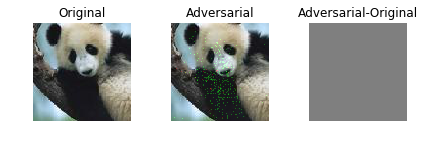

In [4]:
#显示原始图片  抵抗样本 以及两张图之间的差异  其中灰色代表没有差异的像素点
show_images_diff(orig,adversary.original_label,adv,adversary.adversarial_label)
